In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load mw1 dataset
mw1_data = pd.read_csv("/content/drive/MyDrive/CAPSTONE/mw1.csv")

Balancing using GAN

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras import layers

# Load dataset
dataset_path = '/content/drive/MyDrive/CAPSTONE/mw1.csv'
mw1_data = pd.read_csv(dataset_path)

# Preprocess data
X = mw1_data.drop(columns=["Defective"])
y = mw1_data["Defective"]

# Handle missing values
X.replace('?', np.nan, inplace=True)
X = X.astype(float)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Display class distribution before balancing
print("Class distribution before balancing:", Counter(y))

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Determine majority class dynamically
majority_class_label = Counter(y).most_common(1)[0][0]
majority_class_count = Counter(y)[majority_class_label]

# Determine minority class
minority_class_label = 'N' if majority_class_label == 'Y' else 'Y'
minority_class_count = Counter(y)[minority_class_label]

# Calculate number of synthetic samples needed to match majority class
num_synthetic_samples = majority_class_count - minority_class_count

# Define GAN architecture
def build_generator(latent_dim, output_dim):
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(output_dim, activation='sigmoid'))
    return model

def build_discriminator(input_dim):
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

# Define GAN parameters
latent_dim = 100
output_dim = X_imputed.shape[1]
epochs = 10
batch_size = 32

# Build and compile the GAN
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)
gan = build_gan(generator, discriminator)

# Train GAN
for epoch in range(epochs):
    for _ in range(batch_size):
        noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
        synthetic_data = generator.predict(noise)[:batch_size]
        X_combined = np.concatenate([X_imputed, synthetic_data]).astype('float32')
        y_combined = np.concatenate([y_encoded, np.ones((batch_size,))]).astype('float32')  # Convert to float32
        X_combined, y_combined = shuffle(X_combined, y_combined)  # Shuffle combined data
        discriminator_loss = discriminator.train_on_batch(X_combined, y_combined)

        noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
        y_gen = np.ones((batch_size,)).astype('float32')
        generator_loss = gan.train_on_batch(noise, y_gen)

    print(f"Epoch: {epoch}, D Loss: {discriminator_loss}, G Loss: {generator_loss}")

# Generate synthetic defect data
def generate_synthetic_data(generator, num_samples):
    noise = np.random.normal(0, 1, (num_samples, latent_dim)).astype('float32')
    synthetic_data = generator.predict(noise)
    return synthetic_data

synthetic_data = generate_synthetic_data(generator, num_samples=num_synthetic_samples)

# Combine synthetic data with original data
combined_data = np.concatenate([X_imputed, synthetic_data])

# Reshape y to match the shape of the synthetic data
y_reshaped = y_encoded.reshape(-1, 1)

# Concatenate reshaped y with an array of ones
combined_target = np.concatenate([y_reshaped, np.ones((num_synthetic_samples, 1))]).astype('float32')

# Display class distribution after balancing
y_resampled = label_encoder.inverse_transform(combined_target[:, 0].astype(int))
print("Class distribution after balancing:", Counter(y_resampled))

# Save balanced dataset to a new file
balanced_mw1 = pd.DataFrame(data=combined_data, columns=X.columns)
balanced_mw1['Defective'] = combined_target
balanced_mw1.to_csv("/content/drive/MyDrive/CAPSTONE/balanced_mw1_GAN.csv", index=False)


Class distribution before balancing: Counter({'N': 372, 'Y': 31})
1/1 [==============================] - 0s 17ms/step
Epoch: 0, D Loss: [3.0910680294036865, 0.8689655065536499], G Loss: 0.05468972027301788
1/1 [==============================] - 0s 18ms/step
Epoch: 1, D Loss: [0.9522002339363098, 0.8482758402824402], G Loss: 0.01659470796585083
1/1 [==============================] - 0s 18ms/step
Epoch: 2, D Loss: [2.6872849464416504, 0.928735613822937], G Loss: 0.006502807140350342
1/1 [==============================] - 0s 27ms/step
Epoch: 3, D Loss: [3.0027995109558105, 0.931034505367279], G Loss: 0.0030385868158191442
1/1 [==============================] - 0s 18ms/step
Epoch: 4, D Loss: [3.565592050552368, 0.928735613822937], G Loss: 0.0016782694729045033
1/1 [==============================] - 0s 17ms/step
Epoch: 5, D Loss: [1.0532993078231812, 0.9218390583992004], G Loss: 0.0012494642287492752
1/1 [==============================] - 0s 19ms/step
Epoch: 6, D Loss: [0.8255025148391724, 

Difference in balance of data for Problems

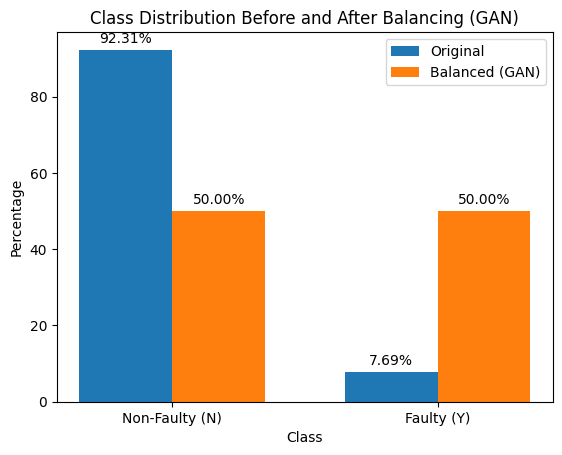

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load original and balanced datasets
original_data = pd.read_csv("/content/drive/MyDrive/CAPSTONE/mw1.csv")
balanced_data = pd.read_csv("/content/drive/MyDrive/CAPSTONE/balanced_mw1_GAN.csv")

# Calculate class distribution before and after balancing
original_class_distribution = original_data['Defective'].value_counts(normalize=True) * 100
balanced_class_distribution = balanced_data['Defective'].value_counts(normalize=True) * 100

# Plot class distribution before and after balancing
labels = ['Non-Faulty (N)', 'Faulty (Y)']
width = 0.35
x = np.arange(len(labels))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_class_distribution, width, label='Original')
rects2 = ax.bar(x + width/2, balanced_class_distribution, width, label='Balanced (GAN)')

ax.set_xlabel('Class')
ax.set_ylabel('Percentage')
ax.set_title('Class Distribution Before and After Balancing (GAN)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add percentage labels on top of the bars
def add_percentage_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_percentage_labels(rects1)
add_percentage_labels(rects2)

plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# from collections import Counter
# from sklearn.utils import shuffle
# from sklearn.preprocessing import LabelEncoder
# from sklearn.impute import SimpleImputer
# from tensorflow import keras
# from tensorflow.keras import layers
# import matplotlib.pyplot as plt

# # Load dataset
# dataset_path = '/content/drive/MyDrive/CAPSTONE/mw1.csv'
# mw1_data = pd.read_csv(dataset_path)

# # Preprocess data
# X = mw1_data.drop(columns=["Defective"])
# y = mw1_data["Defective"]

# # Handle missing values
# X.replace('?', np.nan, inplace=True)
# X = X.astype(float)

# # Impute missing values
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# # Display class distribution before balancing
# print("Class distribution before balancing:", Counter(y))

# # Encode target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Determine majority class dynamically
# majority_class_label = Counter(y).most_common(1)[0][0]
# majority_class_count = Counter(y)[majority_class_label]

# # Determine minority class
# minority_class_label = 'N' if majority_class_label == 'Y' else 'Y'
# minority_class_count = Counter(y)[minority_class_label]

# # Calculate number of synthetic samples needed to match majority class
# num_synthetic_samples = majority_class_count - minority_class_count

# # Define GAN architecture
# def build_generator(latent_dim, output_dim):
#     model = keras.Sequential()
#     model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
#     model.add(layers.Dense(output_dim, activation='sigmoid'))
#     return model

# def build_discriminator(input_dim):
#     model = keras.Sequential()
#     model.add(layers.Dense(128, activation='relu', input_dim=input_dim))
#     model.add(layers.Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# def build_gan(generator, discriminator):
#     discriminator.trainable = False
#     gan_input = layers.Input(shape=(latent_dim,))
#     x = generator(gan_input)
#     gan_output = discriminator(x)
#     gan = keras.Model(gan_input, gan_output)
#     gan.compile(loss='binary_crossentropy', optimizer='adam')
#     return gan

# # Define GAN parameters
# latent_dim = 100
# output_dim = X_imputed.shape[1]
# epochs = 10
# batch_size = 32

# # Lists to store losses
# discriminator_losses = []
# generator_losses = []

# # Build and compile the GAN
# generator = build_generator(latent_dim, output_dim)
# discriminator = build_discriminator(output_dim)
# gan = build_gan(generator, discriminator)

# # Train GAN
# for epoch in range(epochs):
#     for _ in range(batch_size):
#         noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
#         synthetic_data = generator.predict(noise)[:batch_size]
#         X_combined = np.concatenate([X_imputed, synthetic_data]).astype('float32')
#         y_combined = np.concatenate([y_encoded, np.ones((batch_size,))]).astype('float32')  # Convert to float32
#         X_combined, y_combined = shuffle(X_combined, y_combined)  # Shuffle combined data
#         discriminator_loss = discriminator.train_on_batch(X_combined, y_combined)
#         discriminator_losses.append(discriminator_loss[0])

#         noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
#         y_gen = np.ones((batch_size,)).astype('float32')
#         generator_loss = gan.train_on_batch(noise, y_gen)
#         generator_losses.append(generator_loss)

#     print(f"Epoch: {epoch}, D Loss: {discriminator_loss}, G Loss: {generator_loss}")

# # Generate synthetic defect data
# def generate_synthetic_data(generator, num_samples):
#     noise = np.random.normal(0, 1, (num_samples, latent_dim)).astype('float32')
#     synthetic_data = generator.predict(noise)
#     return synthetic_data

# synthetic_data = generate_synthetic_data(generator, num_samples=num_synthetic_samples)

# # Combine synthetic data with original data
# combined_data = np.concatenate([X_imputed, synthetic_data])

# # Reshape y to match the shape of the synthetic data
# y_reshaped = y_encoded.reshape(-1, 1)

# # Concatenate reshaped y with an array of ones
# combined_target = np.concatenate([y_reshaped, np.ones((num_synthetic_samples, 1))]).astype('float32')

# # Display class distribution after balancing
# y_resampled = label_encoder.inverse_transform(combined_target[:, 0].astype(int))
# print("Class distribution after balancing:", Counter(y_resampled))

# # Save balanced dataset to a new file
# balanced_mw1 = pd.DataFrame(data=combined_data, columns=X.columns)
# balanced_mw1['Defective'] = combined_target
# balanced_mw1.to_csv("/content/drive/MyDrive/CAPSTONE/balanced_mw1_GAN.csv", index=False)

# # Plot losses
# plt.figure(figsize=(10, 5))
# plt.plot(discriminator_losses, label='Discriminator Loss')
# plt.plot(generator_losses, label='Generator Loss')
# plt.title('Discriminator and Generator Losses')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

ML model training on GAN Balanced MW1 dataset

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.impute import SimpleImputer

# Load dataset
dataset_path = '/content/drive/MyDrive/CAPSTONE/balanced_mw1_GAN.csv'
balanced_mw1_GAN_data = pd.read_csv(dataset_path)

In [7]:
# Replace '?' with NaN
balanced_mw1_GAN_data.replace('?', np.nan, inplace=True)

# Preprocess data
X = balanced_mw1_GAN_data.drop(columns=["Defective"])
y = balanced_mw1_GAN_data["Defective"]

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random forest classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
classification_report_rf = classification_report(y_test, y_pred_rf)

print("Metrics for Random Forest Classifier:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print("Classification Report:")
print(classification_report_rf)

Metrics for Random Forest Classifier:
Accuracy: 0.9395973154362416
Precision: 0.9433488212011701
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94        77
         1.0       0.98      0.89      0.93        72

    accuracy                           0.94       149
   macro avg       0.94      0.94      0.94       149
weighted avg       0.94      0.94      0.94       149



Support Vector Machine (SVM)

In [9]:
from sklearn.svm import SVC

# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
classification_report_svm = classification_report(y_test, y_pred_svm)

print("Metrics for SVM Classifier:")
print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print("Classification Report:")
print(classification_report_svm)

Metrics for SVM Classifier:
Accuracy: 0.9328859060402684
Precision: 0.935546946786536
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94        77
         1.0       0.97      0.89      0.93        72

    accuracy                           0.93       149
   macro avg       0.94      0.93      0.93       149
weighted avg       0.94      0.93      0.93       149



Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
logistic_classifier = LogisticRegression(random_state=42)
logistic_classifier.fit(X_train, y_train)

# Make predictions
y_pred_logistic = logistic_classifier.predict(X_test)

# Evaluate model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic, average='weighted')
classification_report_logistic = classification_report(y_test, y_pred_logistic)

print("Metrics for Logistic Regression:")
print(f"Accuracy: {accuracy_logistic}")
print(f"Precision: {precision_logistic}")
print("Classification Report:")
print(classification_report_logistic)

Metrics for Logistic Regression:
Accuracy: 0.9328859060402684
Precision: 0.9331383424153794
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94        77
         1.0       0.94      0.92      0.93        72

    accuracy                           0.93       149
   macro avg       0.93      0.93      0.93       149
weighted avg       0.93      0.93      0.93       149



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K-Nearest Neighbors (KNN)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN Classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
classification_report_knn = classification_report(y_test, y_pred_knn)

print("Metrics for KNN Classifier:")
print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print("Classification Report:")
print(classification_report_knn)

Metrics for KNN Classifier:
Accuracy: 0.9395973154362416
Precision: 0.9459185266115188
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94        77
         1.0       1.00      0.88      0.93        72

    accuracy                           0.94       149
   macro avg       0.95      0.94      0.94       149
weighted avg       0.95      0.94      0.94       149



Gradient Boosting

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_classifier.predict(X_test)

# Evaluate model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
classification_report_gb = classification_report(y_test, y_pred_gb)

print("Metrics for Gradient Boosting Classifier:")
print(f"Accuracy: {accuracy_gb}")
print(f"Precision: {precision_gb}")
print("Classification Report:")
print(classification_report_gb)

Metrics for Gradient Boosting Classifier:
Accuracy: 0.9530201342281879
Precision: 0.9569351230425055
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        77
         1.0       1.00      0.90      0.95        72

    accuracy                           0.95       149
   macro avg       0.96      0.95      0.95       149
weighted avg       0.96      0.95      0.95       149



Comparison Between models

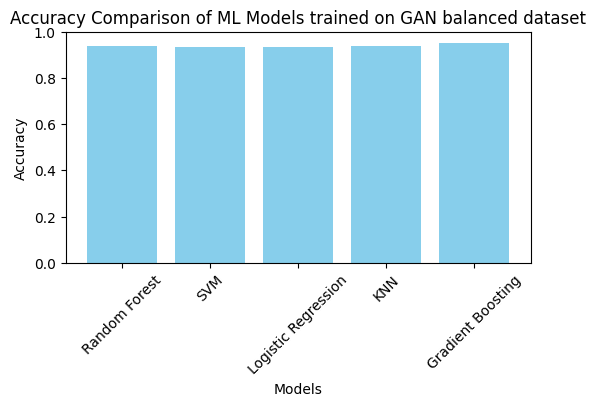

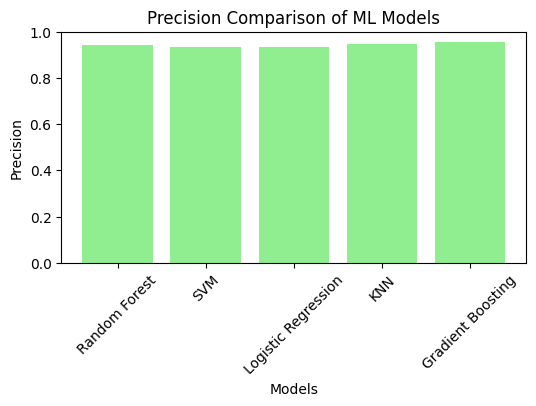

In [13]:
import matplotlib.pyplot as plt

# Metrics for each model
models = ['Random Forest', 'SVM', 'Logistic Regression', 'KNN', 'Gradient Boosting']
accuracies = [accuracy_rf, accuracy_svm, accuracy_logistic, accuracy_knn, accuracy_gb]
precisions = [precision_rf, precision_svm, precision_logistic, precision_knn, precision_gb]

# Plotting accuracy
plt.figure(figsize=(6, 3))
plt.bar(models, accuracies, color='skyblue')
plt.title('Accuracy Comparison of ML Models trained on GAN balanced dataset')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.show()

# Plotting precision
plt.figure(figsize=(6, 3))
plt.bar(models, precisions, color='lightgreen')
plt.title('Precision Comparison of ML Models')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.show()

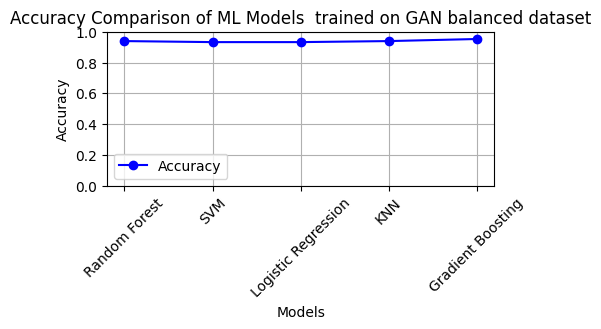

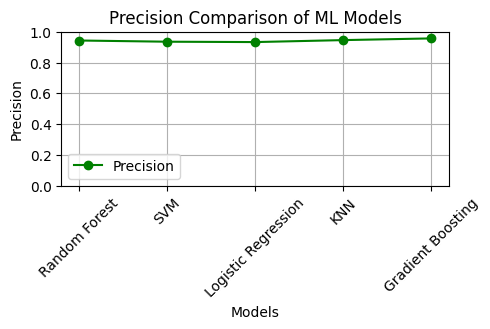

In [14]:
import matplotlib.pyplot as plt

# Metrics for each model
models = ['Random Forest', 'SVM', 'Logistic Regression', 'KNN', 'Gradient Boosting']
accuracies = [accuracy_rf, accuracy_svm, accuracy_logistic, accuracy_knn, accuracy_gb]
precisions = [precision_rf, precision_svm, precision_logistic, precision_knn, precision_gb]

# Plotting accuracy
plt.figure(figsize=(5, 2))
plt.plot(models, accuracies, marker='o', color='blue', label='Accuracy')
plt.title('Accuracy Comparison of ML Models  trained on GAN balanced dataset')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Plotting precision
plt.figure(figsize=(5, 2))
plt.plot(models, precisions, marker='o', color='green', label='Precision')
plt.title('Precision Comparison of ML Models')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()